<h1><span style="background-color: #bfedd2;">Transfer Learning con MobileNetV2 para Clasificaci&oacute;n Binaria de Perros y Gatos</span></h1>

## Objetivo


<p data-start="217" data-end="248">El objetivo de este notebook es desarrollar un modelo de clasificaci&oacute;n de im&aacute;genes para distinguir entre gatos y perros utilizando MobileNetV2 como base preentrenada. El flujo incluye el uso de transfer learning congelando inicialmente las capas del modelo base, seguido de un proceso de fine-tuning para ajustar las capas superiores de MobileNetV2. Se abordan las etapas de carga y preprocesamiento de im&aacute;genes, construcci&oacute;n del modelo, entrenamiento, ajuste fino, evaluaci&oacute;n del rendimiento.</p>

<h3 data-start="217" data-end="248">Sobre M&iacute;</h3>
<p data-start="249" data-end="620">Como analista de datos junior, busco aplicar mis conocimientos en an&aacute;lisis exploratorio, visualizaci&oacute;n y modelos predictivos para aportar valor en la toma de decisiones basada en datos. Me interesa crecer en entornos colaborativos donde pueda aprender de proyectos reales, desarrollar soluciones con impacto y continuar form&aacute;ndome en ciencia de datos aplicada al negocio. Tengo experiencia pr&aacute;ctica en limpieza de datos, visualizaci&oacute;n con herramientas como Matplotlib y Seaborn, y creaci&oacute;n de modelos b&aacute;sicos con scikit-learn y redes neuronales en Keras.&nbsp;</p>
<h6 style="text-align: right;" data-start="249" data-end="620">Romero Olmos, Luis Eduardo<br />Correo: <a href="mailto:luiseduardoromeroolmos@aol.com">luiseduardoromeroolmos@aol.com</a><br />Git: https://github.com/LuisEduardoRomeroOlmos<br />Kaggle: https://www.kaggle.com/luiseduardoromeroolm</h6>

<p><em><strong>Importaci&oacute;n de Librer&iacute;as</strong></em></p>

In [1]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

<p><em><strong>Declaraci&oacute;n de Funciones</strong></em></p>

In [2]:
#Funcion para graficar el historial de entrenamiento
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.title('Evolución del Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
#Funcion para darle preprocesamiento a una imagen individual
def cargar_preprocesar_imagen(ruta_imagen, tamaño=(128, 128)):
    # Cargar y redimensionar
    img = image.load_img(ruta_imagen, target_size=tamaño)
    # Convertir a array
    img_array = image.img_to_array(img)
    # Añadir dimensión para lote (batch size 1)
    img_array = np.expand_dims(img_array, axis=0)
    # Escalar píxeles a rango [0, 1]
    img_array = img_array / 255.0
    return img_array

In [4]:
#Graficar Metricas y busqueda del Threshold
def graficar_metricas_vs_threshold(y_probs, y_true):
    
    thresholds = np.arange(0.0, 1.01, 0.01)
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for t in thresholds:
        y_pred_t = (y_probs >= t).astype(int)
        precision_scores.append(precision_score(y_true, y_pred_t, zero_division=0))
        recall_scores.append(recall_score(y_true, y_pred_t, zero_division=0))
        f1_scores.append(f1_score(y_true, y_pred_t, zero_division=0))

    best_thresh = thresholds[np.argmax(f1_scores)]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best Threshold: {best_thresh:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall y F1 vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
def plot_roc_curve(y_true, y_probs):
    """
    Grafica la curva ROC y muestra el AUC.

    Parámetros:
    - y_true: etiquetas verdaderas (array o lista)
    - y_probs: probabilidades predichas para la clase positiva (array o lista)
    """
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.6f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_precision_recall_curve(y_true, y_probs):
    """
    Grafica la curva Precision-Recall y muestra el Average Precision.

    Parámetros:
    - y_true: etiquetas verdaderas (array o lista)
    - y_probs: probabilidades predichas para la clase positiva (array o lista)
    """
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.6f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

## Preparación y Aumento de Datos para el Modelo CNN


<p>Se utiliza <strong>ImageDataGenerator</strong> para aplicar t&eacute;cnicas de aumento de datos como rotaci&oacute;n, zoom y volteo horizontal, con el fin de incrementar la variedad del conjunto de entrenamiento y mejorar la capacidad de generalizaci&oacute;n del modelo. Adem&aacute;s, se realiza una separaci&oacute;n del 20% para validaci&oacute;n desde el mismo directorio de im&aacute;genes.</p>

In [6]:
# Generador con aumentos solo para entrenamiento
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Divide internamente el 20% como validación
)

# Entrenamiento (80%)
train_data = datagen.flow_from_directory(
    'PetImages',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',      # 80% de los datos
    shuffle=True,
    seed=42
)

# Validación (20%), sin aumentos
val_data = datagen.flow_from_directory(
    'PetImages',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',    # 20% de los datos
    shuffle=False,
    seed=42
)


Found 19968 images belonging to 2 classes.
Found 4991 images belonging to 2 classes.


## Creación e importación del Modelo Preentrenado MobilenetV2

<p data-start="108" data-end="399">Se utiliz&oacute; la arquitectura <strong data-start="135" data-end="175">MobileNetV2 preentrenada en ImageNet</strong> como base para el modelo. Esta red se carga sin su capa superior (<code data-start="242" data-end="261">include_top=False</code>) y se configura inicialmente con todas sus capas <strong data-start="311" data-end="325">congeladas</strong> (<code data-start="327" data-end="344">trainable=False</code>) para preservar el conocimiento previamente aprendido.</p>
<p data-start="401" data-end="550">Sobre esta base se construye una nueva "cabeza" de clasificaci&oacute;n adaptada a la tarea binaria de distinguir entre perros y gatos. Esta cabeza incluye:</p>
<ul data-start="552" data-end="881">
<li data-start="552" data-end="633">
<p data-start="554" data-end="633">Una capa de <strong data-start="566" data-end="592">GlobalAveragePooling2D</strong> para reducir las dimensiones espaciales,</p>
</li>
<li data-start="634" data-end="729">
<p data-start="636" data-end="729">Una capa <strong data-start="645" data-end="690">densa de 256 unidades con activaci&oacute;n ReLU</strong> para introducir capacidad de decisi&oacute;n,</p>
</li>
<li data-start="730" data-end="787">
<p data-start="732" data-end="787">Una capa <strong data-start="741" data-end="760">Dropout del 50%</strong> para prevenir sobreajuste,</p>
</li>
<li data-start="788" data-end="881">
<p data-start="790" data-end="881">Una capa <strong data-start="799" data-end="836">de salida con activaci&oacute;n sigmoide</strong>, ideal para tareas de clasificaci&oacute;n binaria.</p>
</li>
</ul>
<p data-start="883" data-end="1043">El modelo se compila usando el optimizador <strong data-start="926" data-end="934">Adam</strong> y la funci&oacute;n de p&eacute;rdida <strong data-start="959" data-end="982">binary_crossentropy</strong>, com&uacute;nmente utilizada en problemas de clasificaci&oacute;n binaria.</p>

In [7]:
# Cargar el modelo base (sin la capa final)
base_model = MobileNetV2(input_shape=(128, 128, 3),
                         include_top=False,
                         weights='imagenet')

In [8]:
#  Congelas las capas de MobileNet
base_model.trainable = False  

In [9]:
# Crear la cabeza del modelo (clasificación binaria)
head_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # para clasificación binaria
])

In [10]:
# Compilar solo la cabeza
head_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [11]:
head_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento del modelo

#### Entrenamiento de la cabeza

El entrenamiento de la cabeza (o training the head en inglés) se refiere a entrenar solo la parte superior de un modelo basado en transfer learning, es decir, las capas que tú agregas al final del modelo base preentrenado.

In [12]:
# Entrenar solo la cabeza
history = head_model.fit(train_data, validation_data=val_data, epochs=5)

C:\Users\luise\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
566/624 ━━━━━━━━━━━━━━━━━━━━ 29s 505ms/step - accuracy: 0.9141 - loss: 0.2050

C:\Users\luise\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 400s 630ms/step - accuracy: 0.9163 - loss: 0.2002 - val_accuracy: 0.9543 - val_loss: 0.1131
Epoch 2/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 434s 696ms/step - accuracy: 0.9494 - loss: 0.1225 - val_accuracy: 0.9571 - val_loss: 0.1058
Epoch 3/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 496s 795ms/step - accuracy: 0.9564 - loss: 0.1088 - val_accuracy: 0.9521 - val_loss: 0.1147
Epoch 4/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 477s 765ms/step - accuracy: 0.9582 - loss: 0.1100 - val_accuracy: 0.9589 - val_loss: 0.1022
Epoch 5/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 477s 764ms/step - accuracy: 0.9595 - loss: 0.0973 - val_accuracy: 0.9589 - val_loss: 0.0978


####  Fine-Tuning del Modelo Preentrenado

En esta sección se realiza el **fine-tuning** de MobileNetV2, desbloqueando las últimas 55 capas para permitir que se ajusten mejor a la tarea de clasificación binaria (perros vs gatos). Las primeras 100 capas se mantienen congeladas para conservar el conocimiento aprendido previamente en ImageNet.

El modelo se recompila con una **tasa de aprendizaje baja (`1e-5`)**, ideal para ajustes finos sin afectar negativamente los pesos preentrenados.

Se utilizan los siguientes *callbacks* para controlar el entrenamiento:

- **`EarlyStopping`**: detiene el entrenamiento si `val_accuracy` no mejora tras 5 épocas.
- **`ModelCheckpoint`**: guarda automáticamente el mejor modelo según la precisión de validación.
- **`ReduceLROnPlateau`**: reduce la tasa de aprendizaje si `val_loss` se estanca, afinando el aprendizaje.

Finalmente, se entrena el modelo con estas configuraciones por un máximo de 15 épocas.


In [13]:
# Descongelar algunas capas profundas
base_model.trainable = True

# Congelar las primeras N capas, entrenar las últimas (más específicas)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompilar antes de continuar
head_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # tasa más baja
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [14]:
# EarlyStopping para detener entrenamiento si val_accuracy no mejora en 5 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_accuracy',  # métrica a monitorear
    patience=7,              # espera 6 epochs sin mejora para detener
    verbose=1,
    restore_best_weights=True  # restaura los pesos del mejor epoch al final
)

# ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
checkpoint = ModelCheckpoint(
    'MobileV2_Version2.keras',       # ruta donde se guardará el modelo
    monitor='val_accuracy',  # métrica a monitorear
    save_best_only=True,     # guarda solo el mejor modelo
    verbose=1
)

# reduce a la mitad (de 1e-5 a 5e-6, luego a 2.5e-6, etc.)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,        
    patience=3,        # si val_loss no mejora en 3 épocas, reduce LR
    verbose=1,
    min_lr=1e-7        # no baja de 1e-7
)


In [16]:
# Entrenamos el modelo con las capas descongeladas (55)
history2 = head_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.8940 - loss: 0.2594
Epoch 1: val_accuracy improved from -inf to 0.95572, saving model to MobileV2_Version2.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 583s 902ms/step - accuracy: 0.8941 - loss: 0.2593 - val_accuracy: 0.9557 - val_loss: 0.1133 - learning_rate: 1.0000e-05
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.9467 - loss: 0.1326
Epoch 2: val_accuracy improved from 0.95572 to 0.96313, saving model to MobileV2_Version2.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 530s 850ms/step - accuracy: 0.9467 - loss: 0.1326 - val_accuracy: 0.9631 - val_loss: 0.1017 - learning_rate: 1.0000e-05
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9502 - loss: 0.1230
Epoch 3: val_accuracy did not improve from 0.96313
624/624 ━━━━━━━━━━━━━━━━━━━━ 450s 721ms/step - accuracy: 0.9502 - loss: 0.1230 - val_accuracy: 0.9609 - val_loss: 0.0990 - learning_rate: 1.0000e-05
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/

#### Grafico de la evolucion por epoca

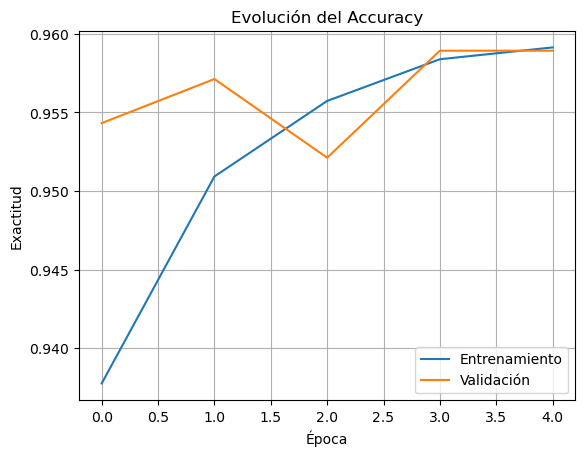

In [17]:
#Evolucion del Accuracy del primer entrenamiento sin descongelar las capas
plot_accuracy(history)

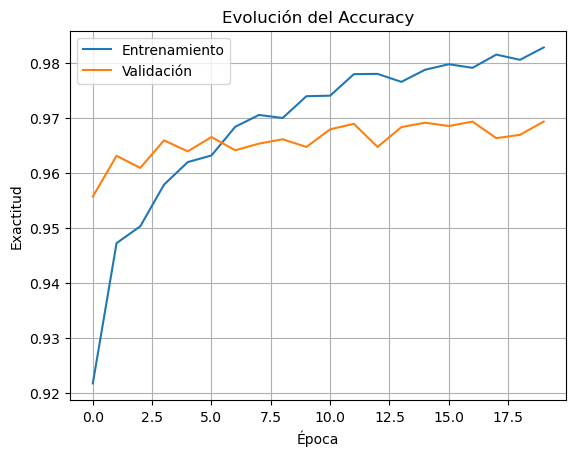

In [18]:
#Evolucion del Accuracy cuando se entrena el modelo con las capas descongeladas
plot_accuracy(history2)

##  Generación de Predicciones y Evaluación del Modelo

<p style="text-align: justify;">Se carg&oacute; el mejor modelo previamente guardado para evaluar su desempe&ntilde;o. A continuaci&oacute;n, se generaron las predicciones sobre el conjunto de prueba en forma de probabilidades. Estas se convirtieron a clases binarias utilizando un umbral de 0.5. Finalmente, se obtuvieron las etiquetas reales del conjunto de prueba para compararlas con las predicciones.</p>

In [19]:
#Cargamos el mejor  Modelo obtenido en el entrenamiento
from keras.models import load_model
best_model = load_model('MobileV2_Version2.keras')

#### Prediccion sobre el conjunto de Prueba

In [20]:
#Obtenemos la matriz de Probabilidades
y_probs = best_model.predict(val_data, verbose=1)

156/156 ━━━━━━━━━━━━━━━━━━━━ 71s 445ms/step


In [21]:
# Umbral por defecto de 0.5, convertimos a un vector
y_pred = (y_probs >= 0.50).astype(int)  

In [22]:
# Esto te da los 0s y 1s reales del test_set
y_true = val_data.classes  

#### Metricas sobre el conjunto de Prueba

In [23]:
#Accuracy, precision, recall y f-score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2498
           1       0.96      0.97      0.97      2493

    accuracy                           0.97      4991
   macro avg       0.97      0.97      0.97      4991
weighted avg       0.97      0.97      0.97      4991



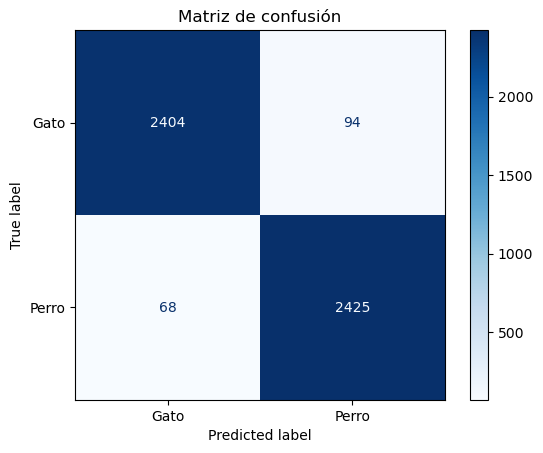

In [24]:
# Matriz de Confusion
cm = confusion_matrix(y_true, y_pred)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=['Gato', 'Perro'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusión')
plt.show()

<p><strong data-start="63" data-end="78">Conclusi&oacute;n:</strong><br data-start="78" data-end="81" />El modelo basado en <em data-start="101" data-end="120">Transfer Learning</em> con MobileNetV2 alcanz&oacute; un excelente desempe&ntilde;o en la clasificaci&oacute;n de im&aacute;genes de perros y gatos. Con una <strong data-start="227" data-end="255">precisi&oacute;n global del 96%</strong>, y valores equilibrados de <em data-start="283" data-end="294" data-is-only-node="">precision</em>, <em data-start="296" data-end="304">recall</em> y <em data-start="307" data-end="317">f1-score</em> para ambas clases, demuestra ser altamente efectivo y generalizable. Esto confirma que el uso de modelos preentrenados, junto con un ajuste fino adecuado, es una estrategia robusta para problemas de clasificaci&oacute;n binaria con conjuntos de im&aacute;genes moderadamente grandes.</p>

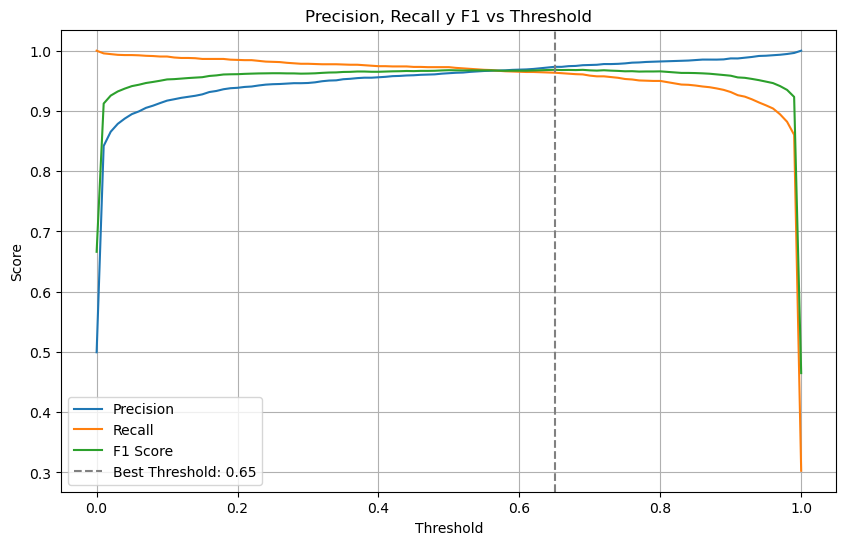

In [25]:
#Precision, Recall, f1 score
graficar_metricas_vs_threshold(y_probs, y_true)

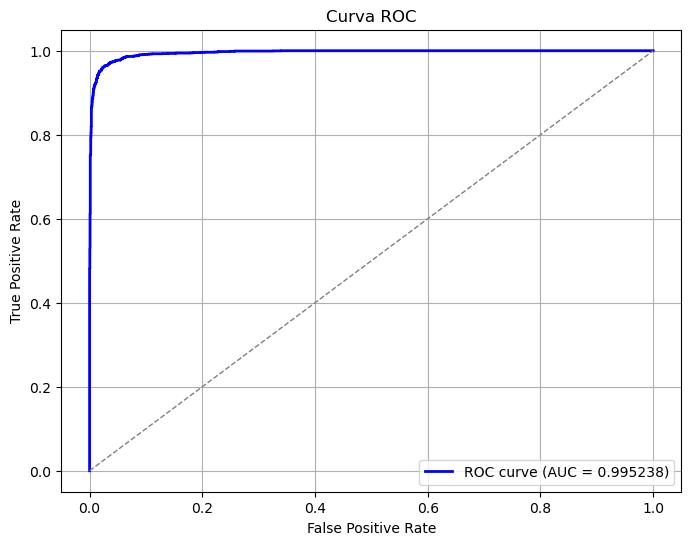

In [26]:
#Curva ROC
plot_roc_curve(y_true, y_probs)

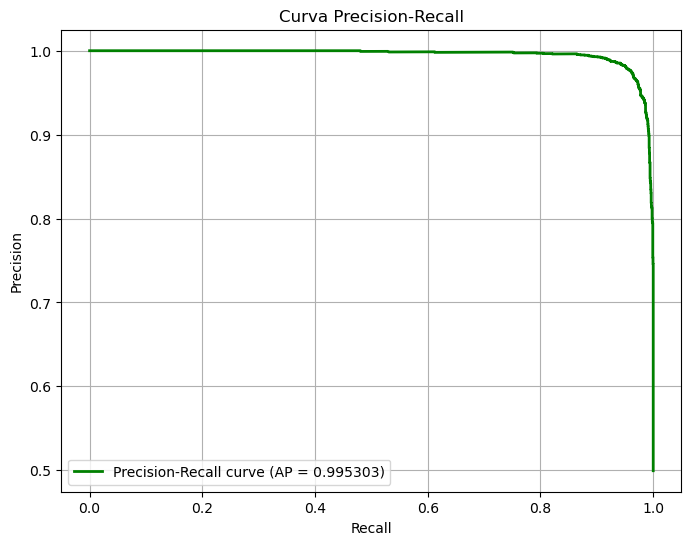

In [27]:
#Curva Precicion - recall
plot_precision_recall_curve(y_true, y_probs)

<p><strong data-start="140" data-end="161">Conclusi&oacute;n Final:</strong><br data-start="161" data-end="164" />El modelo entrenado con <em data-start="188" data-end="207">Transfer Learning</em> usando MobileNetV2 demostr&oacute; un rendimiento excepcional en la clasificaci&oacute;n de im&aacute;genes de perros y gatos. Con una <strong data-start="322" data-end="350">precisi&oacute;n global del 97%</strong> y m&eacute;tricas AUC = <strong data-start="368" data-end="378" data-is-only-node="">0.9952</strong> y AP = <strong data-start="386" data-end="396">0.9953</strong>, se evidencia una alta capacidad de discriminaci&oacute;n entre clases y una gran robustez del modelo. Estos resultados reflejan un entrenamiento bien ajustado, con una excelente generalizaci&oacute;n sobre el conjunto de prueba.</p>

## Prueba de Fuego

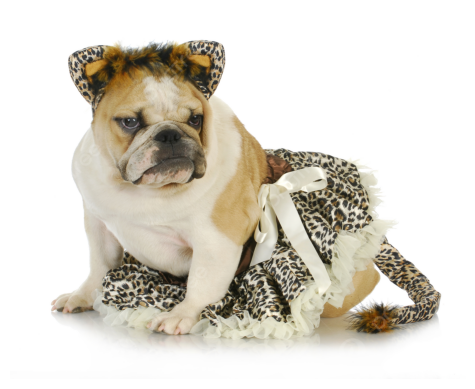

In [78]:
img = mpimg.imread('prueba_fuego/perro.jpg')
plt.imshow(img)
plt.axis('off')  # para quitar los ejes
plt.show()

In [80]:
#Aplicamos el preprocesado a la imagen
img = cargar_preprocesar_imagen("prueba_fuego/perro.jpg")

In [81]:
# Predecir la imagen
prediction = best_model.predict(img)

#Interpretar resultado
if prediction[0][0] > 0.5:
    print("Predicción: Es un perro")
else:
    print("Predicción: Es un gato")

# Valor de predicción 
print("Valor de predicción :", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicción: Es un perro
Valor de predicción : [0.9932288]


## Streamlit

<p style="text-align: justify;">Se desarroll&oacute; una aplicaci&oacute;n web interactiva utilizando Streamlit para mostrar los resultados del modelo de clasificaci&oacute;n de im&aacute;genes de perros y gatos. La aplicaci&oacute;n permite al usuario cargar una imagen desde su dispositivo, y el modelo predice la clase correspondiente utilizando una red neuronal convolucional previamente entrenada. La interfaz es sencilla e intuitiva, y sirve como demostraci&oacute;n pr&aacute;ctica del despliegue de modelos de deep learning en producci&oacute;n.</p>

<p><a href="https://pruebasmobilenetv2-fine-tuning.streamlit.app/" target="_blank" rel="noopener">https://pruebasmobilenetv2-fine-tuning.streamlit.app/</a></p>
